<a href="https://colab.research.google.com/github/Adam-Yasser/Medical-Imaging-Based-Bone-Fracture-Detection-Using-YOLOv8/blob/main/The_complete_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics -q
!yolo task=detect mode=info

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
!kaggle datasets download -d mohammedmohsen0404/bone-fracture-dataset-good-data
!unzip -q bone-fracture-dataset-good-data.zip -d /content/bone_fracture_good_data

!kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project
!unzip -q bone-fracture-detection-computer-vision-project.zip -d /content/bone_fracture_dataset/

Dataset URL: https://www.kaggle.com/datasets/mohammedmohsen0404/bone-fracture-dataset-good-data
License(s): apache-2.0
 88% 15.0M/17.0M [00:00<00:00, 28.9MB/s]
100% 17.0M/17.0M [00:00<00:00, 32.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
 82% 69.0M/84.1M [00:00<00:00, 159MB/s]
100% 84.1M/84.1M [00:00<00:00, 141MB/s]


In [ ]:
base_path = "/content/bone_fracture_good_data"

train_images = os.path.join(base_path, "train/images")
train_labels = os.path.join(base_path, "train/labels")

val_images = os.path.join(base_path, "valid/images")
val_labels = os.path.join(base_path, "valid/labels")

test_images = os.path.join(base_path, "test/images")
test_labels = os.path.join(base_path, "test/labels")

for path in [train_images, train_labels, val_images, val_labels, test_images, test_labels]:
    if not os.path.exists(path):
        print(f" Warning: Path does not exist → {path}")
    else:
        print(f" Path exists → {path}")

 Path exists → /content/bone_fracture_good_data/train/images
 Path exists → /content/bone_fracture_good_data/train/labels
 Path exists → /content/bone_fracture_good_data/valid/images
 Path exists → /content/bone_fracture_good_data/valid/labels
 Path exists → /content/bone_fracture_good_data/test/images
 Path exists → /content/bone_fracture_good_data/test/labels


In [ ]:
def count_files(directory):
    return len(os.listdir(directory)) if os.path.exists(directory) else 0

train_frames = count_files(train_images)
train_labels_count = count_files(train_labels)
val_frames = count_files(val_images)
val_labels_count = count_files(val_labels)
test_frames = count_files(test_images)
test_labels_count = count_files(test_labels)

total_frames = train_frames + val_frames + test_frames

print("=" * 40)
print("Dataset Summary")
print("=" * 40)
print(f"Train Images:  {train_frames}")
print(f"Train Labels:  {train_labels_count}")
print("-" * 30)
print(f"Validation Images:  {val_frames}")
print(f"Validation Labels:  {val_labels_count}")
print("-" * 30)
print(f"Test Images:   {test_frames}")
print(f"Test Labels:   {test_labels_count}")
print("=" * 40)
print(f"Total Images in Dataset: {total_frames}")
print("=" * 40)

Dataset Summary
Train Images:  1530
Train Labels:  1530
------------------------------
Validation Images:  23
Validation Labels:  23
------------------------------
Test Images:   53
Test Labels:   53
Total Images in Dataset: 1606


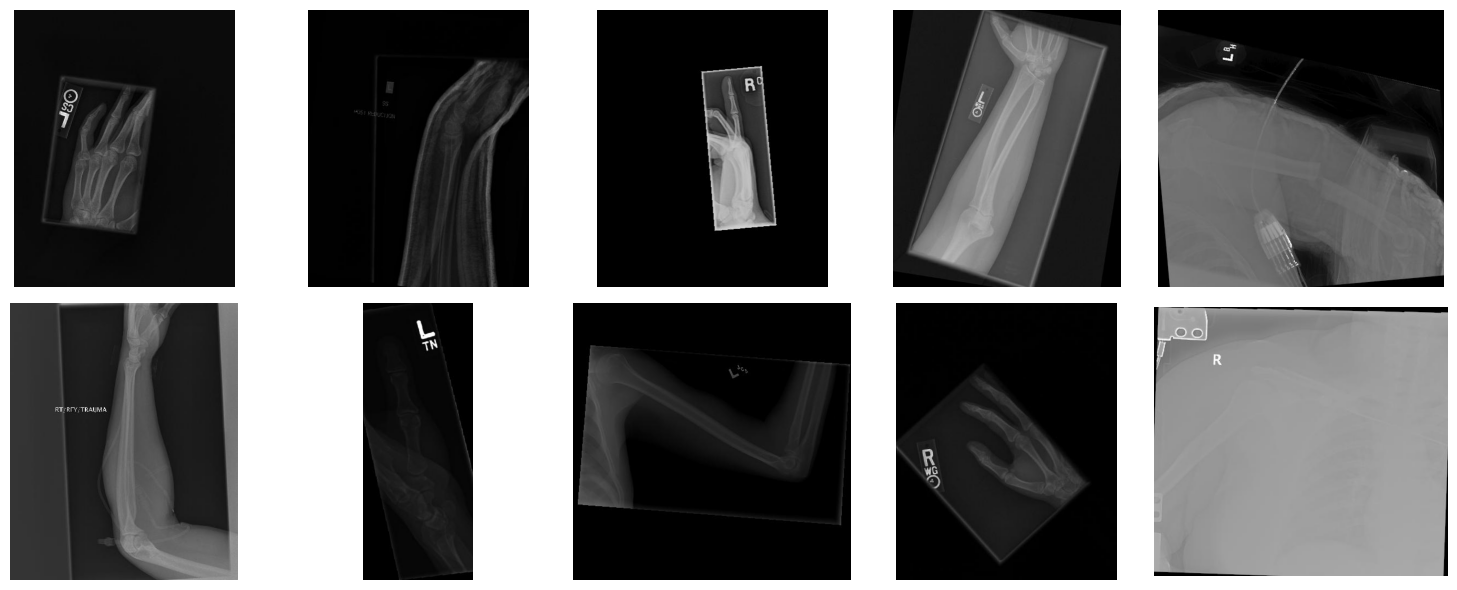

In [ ]:
def visualize_dataset_images(image_folder, num_images=10):
    image_files = [
        os.path.join(image_folder, f)
        for f in os.listdir(image_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 6))

    rows, cols = 2, 5

    for idx, file_path in enumerate(selected_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_rgb)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

dataset_images_folder = "/content/bone_fracture_dataset/BoneFractureYolo8/train/images"
visualize_dataset_images(dataset_images_folder, num_images=10)

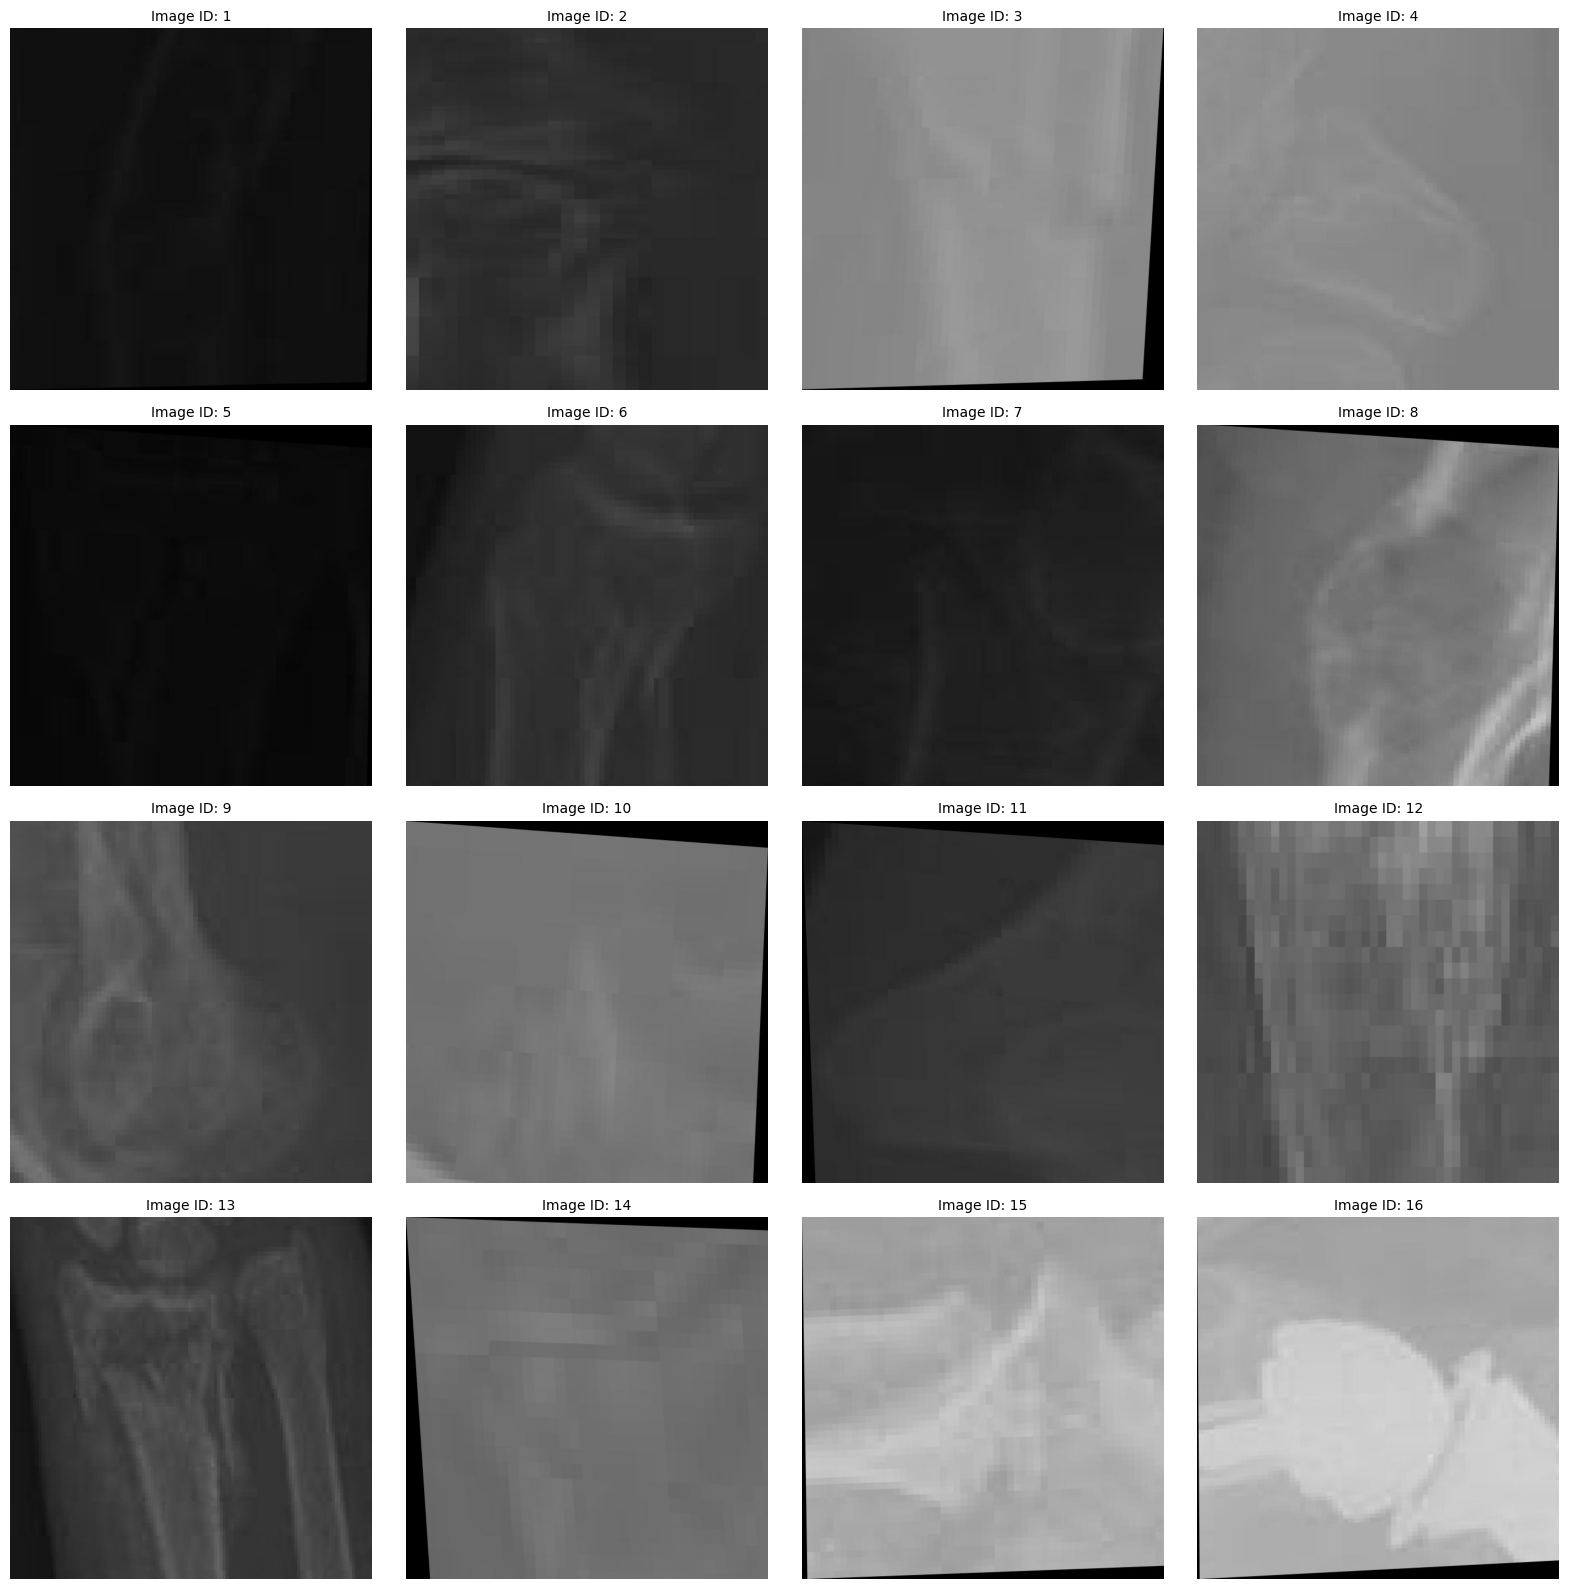

In [ ]:
if not os.path.exists(train_images) or len(os.listdir(train_images)) == 0:
    print("Training images directory is empty or missing.")
else:
    image_files = os.listdir(train_images)

    num_images = min(16, len(image_files))
    random_images = random.sample(image_files, num_images)

    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    axs = axs.flatten()

    for i, image_file in enumerate(random_images):
        image_path = os.path.join(train_images, image_file)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Unable to load image {image_file}. Skipping.")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(train_labels, label_file)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                labels = f.read().strip().split("\n")

            for label in labels:
                parts = label.split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    x_min = int((x_center - width / 2) * image.shape[1])
                    y_min = int((y_center - height / 2) * image.shape[0])
                    x_max = int((x_center + width / 2) * image.shape[1])
                    y_max = int((y_center + height / 2) * image.shape[0])
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(f"Image ID: {i+1}", fontsize=10)

    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
image_files = os.listdir(train_images)

if len(image_files) == 0:
    print("No images found in the dataset directory.")
else:
    random_image_file = random.choice(image_files)
    image_path = os.path.join(train_images, random_image_file)

    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {random_image_file}")
    else:
        height, width, channels = image.shape
        print(f"Selected Image: {random_image_file}")
        print(f"Image Dimensions: {width}x{height} pixels with {channels} channels.")

Selected Image: image1_1329_png_jpg.rf.fc3838cc754daab29011999158f58e5c.jpg
Image Dimensions: 640x640 pixels with 3 channels.


In [ ]:
best_model_path = "/content/bone_fracture_yolo/yolov8s_experiment/weights/best.pt"

if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"Model file not found: {best_model_path}")

model = YOLO(best_model_path)

metrics = model.val(conf=0.25, split='test')

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/bone_fracture_good_data/test/labels... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<00:00, 1950.69it/s]

val: New cache created: /content/bone_fracture_good_data/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


                   all         53         53          1          1      0.995      0.994
Speed: 6.6ms preprocess, 16.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


In [ ]:
def detect_fracture(img_path, return_results=False):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Error: Image path does not exist -> {img_path}")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Error: Unable to load image -> {img_path}")

    if 'model' not in globals():
        raise NameError("Error: YOLO model is not loaded. Make sure to initialize it before calling this function.")

    detect_result = model.predict(img_path, conf=0.5)

    detect_img = detect_result[0].plot()

    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return (detect_img, detect_result) if return_results else detect_img

<Figure size 1000x500 with 0 Axes>

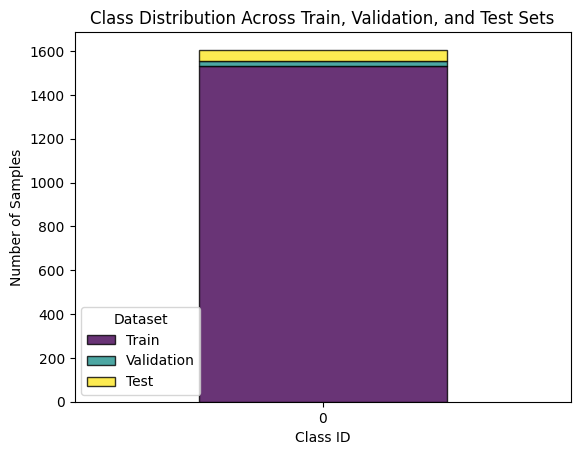

In [ ]:
def get_class_distribution(labels_folder):
    class_counts = {}

    for label_file in os.listdir(labels_folder):
        with open(os.path.join(labels_folder, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    return class_counts

train_classes = get_class_distribution(train_labels)
val_classes = get_class_distribution(val_labels)
test_classes = get_class_distribution(test_labels)

df = pd.DataFrame([train_classes, val_classes, test_classes], index=['Train', 'Validation', 'Test']).T
df.fillna(0, inplace=True)

plt.figure(figsize=(10, 5))
df.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', alpha=0.8)
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=0)
plt.legend(title="Dataset")
plt.show()

In [ ]:
detect_result = model.predict(img_path, conf=0.25)
print(detect_result[0].boxes)


image 1/1 /content/bone_fracture_good_data/test/images/image1_3017_png_jpg.rf.a7e3977ac622716993d2bfd6936b6fe4.jpg: 640x640 1 fracture, 19.3ms
Speed: 3.0ms preprocess, 19.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9943], device='cuda:0')
data: tensor([[1.1633e-01, 1.0779e-01, 6.4000e+02, 6.3996e+02, 9.9434e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[320.0582, 320.0354, 639.8837, 639.8552]], device='cuda:0')
xywhn: tensor([[0.5001, 0.5001, 0.9998, 0.9998]], device='cuda:0')
xyxy: tensor([[1.1633e-01, 1.0779e-01, 6.4000e+02, 6.3996e+02]], device='cuda:0')
xyxyn: tensor([[1.8177e-04, 1.6842e-04, 1.0000e+00, 9.9994e-01]], device='cuda:0')


In [ ]:
model.train(
    data='/content/bone_fracture_good_data/data.yaml',
    epochs=35,
    imgsz=640,
    batch=16,
    seed=42,
    device=device,
    amp=True,
    project="/content/bone_fracture_yolo",
    name="yolov8s_experiment",
    exist_ok=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=30.0,
    translate=0.2,
    scale=0.5,
    shear=15.0,
    flipud=0.5,
    fliplr=0.5,
)

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/bone_fracture_yolo/yolov8s_experiment/weights/best.pt, data=/content/bone_fracture_good_data/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/bone_fracture_yolo, name=yolov8s_experiment, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning /content/bone_fracture_good_data/train/labels.cache... 1530 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1530/1530 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/bone_fracture_good_data/valid/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]


Plotting labels to /content/bone_fracture_yolo/yolov8s_experiment/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/bone_fracture_yolo/yolov8s_experiment
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      6.33G       1.27     0.9692      1.834         32        640: 100%|██████████| 96/96 [00:33<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         23         23      0.955          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      6.02G      1.231      1.003      1.793         30        640: 100%|██████████| 96/96 [00:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         23         23          1       0.98      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      6.15G      1.218     0.9803      1.772         36        640: 100%|██████████| 96/96 [00:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         23         23      0.842      0.826      0.893      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      6.15G      1.244      0.988      1.802         35        640: 100%|██████████| 96/96 [00:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         23         23      0.953          1      0.983      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      6.15G      1.226     0.9745      1.779         32        640: 100%|██████████| 96/96 [00:29<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         23         23      0.991          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      6.15G       1.22     0.9598      1.763         38        640: 100%|██████████| 96/96 [00:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         23         23          1      0.998      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      6.15G       1.23     0.9677      1.774         30        640: 100%|██████████| 96/96 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         23         23      0.954          1      0.992      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      6.15G      1.203     0.9592      1.746         34        640: 100%|██████████| 96/96 [00:30<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         23         23      0.998          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      6.15G      1.185     0.9318      1.735         39        640: 100%|██████████| 96/96 [00:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         23         23      0.963      0.913      0.978      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      6.15G      1.196     0.9708      1.746         36        640: 100%|██████████| 96/96 [00:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         23         23       0.95          1      0.988      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      6.15G      1.197     0.9418      1.732         30        640: 100%|██████████| 96/96 [00:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         23         23       0.92      0.957      0.948      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      6.15G       1.19     0.9242      1.732         35        640: 100%|██████████| 96/96 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         23      0.955          1      0.993      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      6.15G       1.19     0.9481      1.731         33        640: 100%|██████████| 96/96 [00:29<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         23         23      0.955          1      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      6.15G       1.17     0.9445      1.725         38        640: 100%|██████████| 96/96 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         23         23      0.978          1      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      6.15G      1.174     0.9317      1.715         34        640: 100%|██████████| 96/96 [00:29<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         23         23      0.989      0.957      0.955      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      6.15G      1.179     0.9332      1.728         34        640: 100%|██████████| 96/96 [00:32<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         23      0.954          1      0.992      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      6.15G      1.149     0.9294      1.701         37        640: 100%|██████████| 96/96 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         23      0.957          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      6.15G      1.162     0.9074      1.709         32        640: 100%|██████████| 96/96 [00:32<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         23         23      0.957          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      6.15G      1.158     0.9246      1.701         31        640: 100%|██████████| 96/96 [00:33<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         23         23      0.956          1      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      6.15G      1.151     0.9179      1.698         33        640: 100%|██████████| 96/96 [00:36<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         23         23      0.957          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      6.15G      1.137     0.8995      1.689         37        640: 100%|██████████| 96/96 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         23         23      0.955          1       0.99      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      6.15G      1.151     0.9179      1.691         30        640: 100%|██████████| 96/96 [00:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         23         23      0.955          1      0.986      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      6.15G      1.123     0.9103       1.68         28        640: 100%|██████████| 96/96 [00:30<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         23         23      0.956          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      6.15G      1.126     0.9198      1.677         31        640: 100%|██████████| 96/96 [00:29<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         23         23      0.956          1      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      6.15G       1.14     0.9071      1.693         33        640: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         23         23       0.99          1      0.995      0.914


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      6.15G     0.6839     0.3647      1.652         10        640: 100%|██████████| 96/96 [00:29<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         23         23      0.998          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      6.15G     0.6596     0.2762      1.628         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         23         23      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      6.15G     0.6394     0.2589      1.602         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         23      0.998          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      6.15G     0.6822     0.2682      1.635         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         23         23      0.998          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      6.15G     0.6791     0.2638      1.638         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         23         23      0.998          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      6.15G     0.6616     0.2626      1.627         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      6.15G     0.6504     0.2538      1.615         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         23         23      0.998          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      6.15G     0.6579     0.2512      1.614         10        640: 100%|██████████| 96/96 [00:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         23         23      0.998          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      6.15G     0.6711     0.2516       1.62         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         23         23      0.998          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      6.15G     0.6603     0.2508      1.615         10        640: 100%|██████████| 96/96 [00:28<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         23         23      0.998          1      0.995      0.974



35 epochs completed in 0.307 hours.
Optimizer stripped from /content/bone_fracture_yolo/yolov8s_experiment/weights/last.pt, 22.5MB
Optimizer stripped from /content/bone_fracture_yolo/yolov8s_experiment/weights/best.pt, 22.5MB

Validating /content/bone_fracture_yolo/yolov8s_experiment/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


                   all         23         23      0.998          1      0.995      0.995
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/bone_fracture_yolo/yolov8s_experiment


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7949fabbac90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

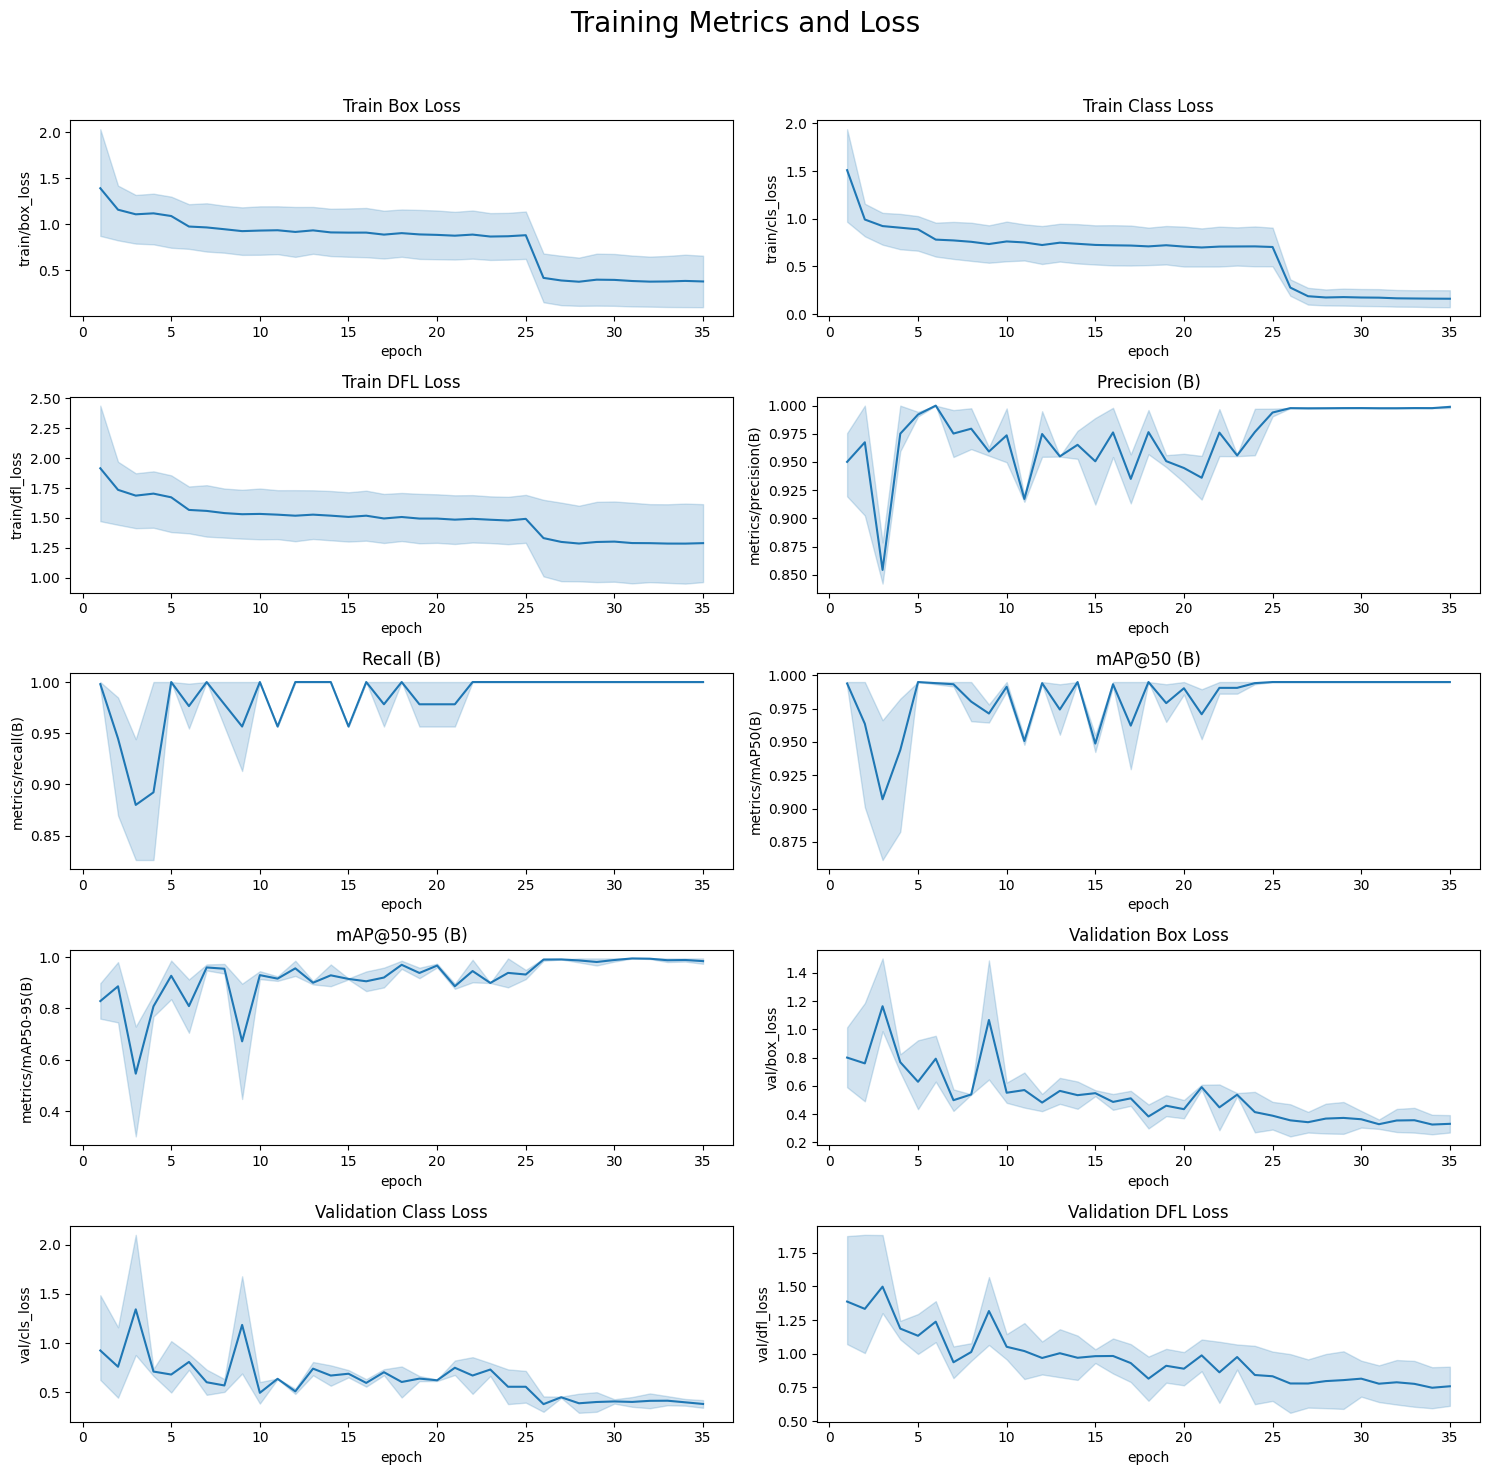

In [ ]:
results_path = "/content/bone_fracture_yolo/yolov8s_experiment/results.csv"

if not os.path.exists(results_path):
    raise FileNotFoundError(f"Results file not found: {results_path}")

df = pd.read_csv(results_path)
df.columns = df.columns.str.strip()

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

metrics = [
    ('epoch', 'train/box_loss', 'Train Box Loss'),
    ('epoch', 'train/cls_loss', 'Train Class Loss'),
    ('epoch', 'train/dfl_loss', 'Train DFL Loss'),
    ('epoch', 'metrics/precision(B)', 'Precision (B)'),
    ('epoch', 'metrics/recall(B)', 'Recall (B)'),
    ('epoch', 'metrics/mAP50(B)', 'mAP@50 (B)'),
    ('epoch', 'metrics/mAP50-95(B)', 'mAP@50-95 (B)'),
    ('epoch', 'val/box_loss', 'Validation Box Loss'),
    ('epoch', 'val/cls_loss', 'Validation Class Loss'),
    ('epoch', 'val/dfl_loss', 'Validation DFL Loss'),
]

for ax, (x, y, title) in zip(axs.flat, metrics):
    sns.lineplot(x=x, y=y, data=df, ax=ax)
    ax.set_title(title)

plt.suptitle('Training Metrics and Loss', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

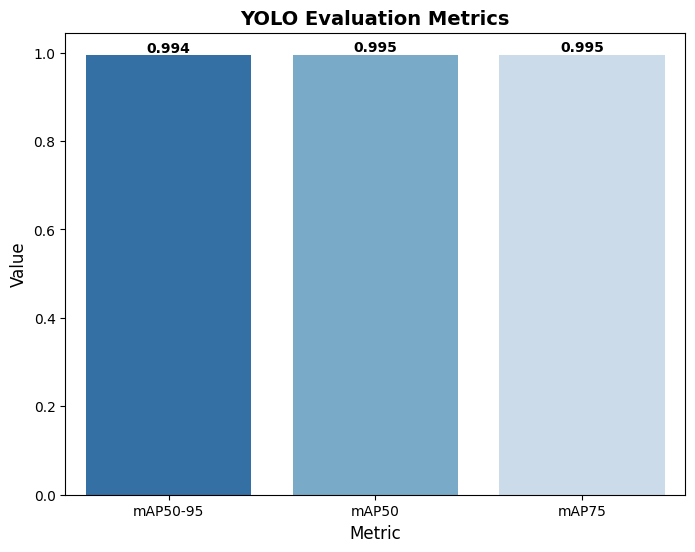

In [ ]:
if hasattr(metrics.box, 'map') and hasattr(metrics.box, 'map50') and hasattr(metrics.box, 'map75'):
    metric_values = [metrics.box.map, metrics.box.map50, metrics.box.map75]
    metric_labels = ['mAP50-95', 'mAP50', 'mAP75']

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=metric_labels, y=metric_values, palette="Blues_r")

    ax.set_title('YOLO Evaluation Metrics', fontsize=14, fontweight='bold')
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()
else:
    print("Error: One or more evaluation metrics are missing from the model output.")


image 1/1 /content/bone_fracture_good_data/test/images/image1_2420_png_jpg.rf.7d578c16e679560bea8e0553c3408b6d.jpg: 640x640 1 fracture, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/bone_fracture_good_data/test/images/image2_2819_png_jpg.rf.dd9352a8a3e6d088fac9a803ed892437.jpg: 640x640 1 fracture, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/bone_fracture_good_data/test/images/image1_1150_png_jpg.rf.bc25480ad2833416a0d1ce6f0e86e471.jpg: 640x640 1 fracture, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/bone_fracture_good_data/test/images/fracture-of-the-humeral-capitellum-milch-type-1-1-1-_jpg.rf.a2651e72143b65e1a2495f6b6ffa4a72.jpg: 640x640 1 fracture, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

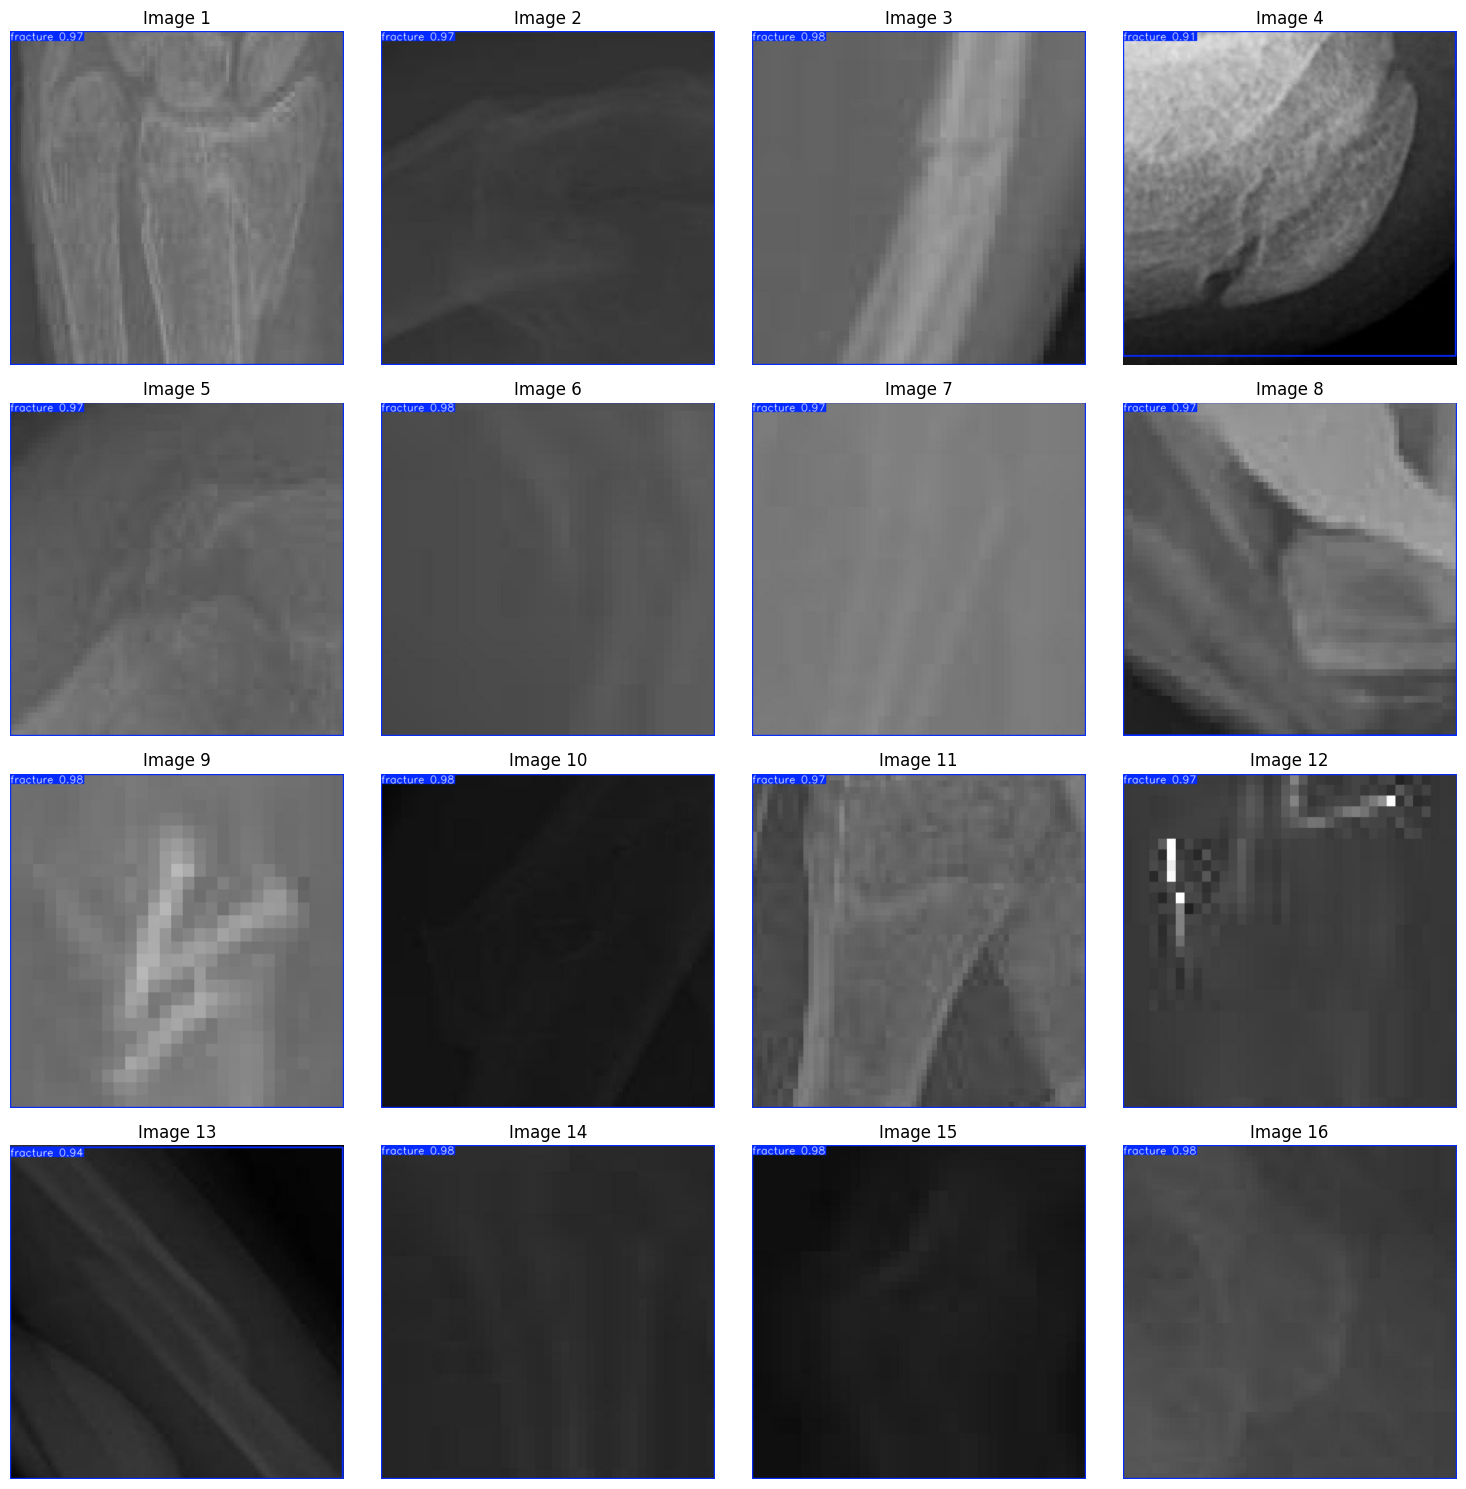

In [ ]:
model = YOLO("/content/bone_fracture_yolo/yolov8s_experiment/weights/best.pt")

def visualize_predictions(image_folder, num_samples=16):
    image_files = [
        os.path.join(image_folder, f)
        for f in os.listdir(image_folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    selected_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()

    for i, img_path in enumerate(selected_files):
        results = model.predict(img_path, conf=0.3)

        detect_img = results[0].plot()

        detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(detect_img)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")

    for j in range(i + 1, len(axes)):
        axes[j].axis("on")

    plt.tight_layout()
    plt.show()

visualize_predictions(test_images)

##UMAP/T-SNE Embeddings for Model Feature Space

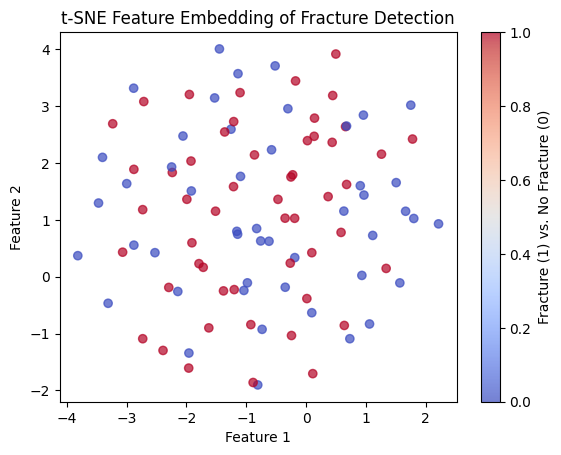

In [ ]:
X = np.random.rand(100, 512)
labels = np.random.randint(0, 2, 100)

X_embedded = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("t-SNE Feature Embedding of Fracture Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Fracture (1) vs. No Fracture (0)")
plt.show()

# End of the notebook
